In [1]:
import numpy as np
import matplotlib.pyplot as plt


class TSP:

    def __init__(self, no_of_nodes: int=10, predefined_nodes=None, seed=None):
        """
        An instance of the Travelling Salesman Problem. Uses a predefined seed
        unless a seed is provided during creation. Can also use predefined nodes,
        but if they are not given, generates nodes randomly using the seed.
        """
        if predefined_nodes is not None:
            self.nodes = copy.copy(predefined_nodes)
        else:
            # You can alter the seed during your experiments, but please run the last version with the provided seed
            self.seed = 5075 if seed is None else seed
            rng = np.random.default_rng(self.seed)
            print(f"Using random seed {self.seed}")
            self.nodes = np.array([(rng.random(), rng.random()) for _ in range(no_of_nodes)])
        x, y = zip(*self.nodes)
        self.x, self.y = np.array(x), np.array(y)

    def evaluate(self, visit_order, include_travel_back=True):
        """
        Calculates the total distance travelled when visiting nodes in the given
        visit order.
        """
        return sum(self.distances(visit_order, include_travel_back=include_travel_back))

    def plot(self, edges=None, show=True, show_order=False, title=None, figsize=(6,6)):
        """
        Creates a plot with the nodes, with edges if provided.
        """
        fig, ax = plt.subplots(figsize=figsize)
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        if edges is None:
            # Draw nodes without the edges
            ax.scatter(self.x, self.y)
        else:
            # Draw nodes with edges
            ax.plot(self.x[edges], self.y[edges], "b-o")
            # Add the travel back to origin
            ax.plot([self.x[edges][0], self.x[edges][-1]], [self.y[edges][0], self.y[edges][-1]], "b-o")
        if show_order:
            for i, n in enumerate(self.nodes):
                ax.annotate(str(i), (n[0]+0.005, n[1]+0.005))
        if title is not None:
            plt.title(title)
        if show:
            plt.show()

    def distances(self, visit_order, include_travel_back=True):
        """
        Calculates and returns the distances from node to node, 
        if include_travel_back is True, also includes travel back to the origin.
        """
        distances = []
        for i in range(len(visit_order) - 1):
            dist = np.linalg.norm(self.nodes[visit_order[i]] - self.nodes[visit_order[i + 1]])
            distances.append(dist)
        if include_travel_back:
            dist = np.linalg.norm(self.nodes[visit_order[0]] - self.nodes[visit_order[-1]])
            distances.append(dist)
        return distances


In [2]:
from scipy.spatial import distance_matrix
import copy

class GreedySolver:

    def __init__(self, tsp_instance):
        self.tsp_instance = tsp_instance
        # Create a distance matrix only once; we'll use it later
        self.dist_matrix = distance_matrix(tsp_instance.nodes, tsp_instance.nodes)
        # Setting the diagonal from 0 to infinity because it interferes with
        # calculations below
        for i in range(len(self.dist_matrix)):
            self.dist_matrix[i,i] = np.inf
    
    def get_solutions(self):
        """
        Picks every node as a starting point, creating a solution around it.
        Iterates over all remaining nodes and picks the closest node as the 
        next node to visit. Returns as many solutions as there are nodes.
        """
        solutions = []
        for i,e in enumerate(self.tsp_instance.nodes):
            solution = [i]
            # Copy the distance matrix since we are changing it
            dist_matrix_copy = copy.copy(self.dist_matrix)
            while len(solution) < len(self.tsp_instance.nodes):
                index_of_last = solution[len(solution) - 1]
                distances = dist_matrix_copy[index_of_last]
                indices = range(len(distances))
                zipped = zip(indices, distances)
                ordered = sorted(zipped, key=lambda x: x[1])
                for node in ordered:
                    if node[0] not in solution:
                        solution.append(node[0])
                        break
            solutions.append(solution)
        return solutions

In [3]:
import random

def create_random_population(size: int, no_of_nodes: int):
    population = []
    
    for i in range(size):
        population.append(random.sample(range(no_of_nodes), no_of_nodes))
    
    return population

In [4]:
# Testing random population creation
size = 101
no_of_nodes = 17

population = create_random_population(size, no_of_nodes)
assert len(population) == size

expected_values = list(range(no_of_nodes))
for individual in population:
    for value in expected_values:
        assert value in individual

In [5]:
def mutate(individual):
    individual = copy.copy(individual)
    index1 = random.randint(0, len(individual) - 1)
    index2 = random.randint(0, len(individual) - 1)
    individual[index1], individual[index2] = individual[index2], individual[index1]
    return individual

In [6]:
import math

def select(population, fitnesses):
    new_population = []
    
    for i in range(len(population)):
        index1 = random.randint(0, len(population) - 1)
        index2 = random.randint(0, len(population) - 1)
        
        if fitnesses[index1] < fitnesses[index2]:
            new_population.append(population[index1])
        else:
            new_population.append(population[index2])


    return new_population

In [7]:
class EvolutionWrapper:
    def __init__(self, 
                 initial_population, 
                 selection_fn, 
                 mutation_fn, 
                 evaluation_fn, 
                 crossover_fn = None):
        
        self.population = copy.deepcopy(initial_population)
        self.fitnesses = [evaluation_fn(e) for e in self.population]
        self.selection_fn = selection_fn
        self.mutation_fn = mutation_fn
        self.crossover_fn = crossover_fn
        self.evaluation_fn = evaluation_fn
        self.fitness_history = []
    
    def step(self):
        """
        Creates a new generation from the previous generation, using the operators
        provided during object creation. Also tracks the best fitness in every
        generation. Returns children and fitnesses.
        """
        selection = self.selection_fn(self.population, self.fitnesses)
        children = selection if self.crossover_fn is None else self.crossover_fn(selection)
        children = [self.mutation_fn(e) for e in children]
        children_fitnesses = [self.evaluation_fn(e) for e in children]

        combined_population = np.array(self.population + children)
        combined_fitnesses = np.array(self.fitnesses + children_fitnesses)
        amount = len(self.population)
        indices_of_survivors = np.argpartition(combined_fitnesses, amount)[:amount]
        children = [e.tolist() for e in combined_population[indices_of_survivors]]


        self.fitnesses = [self.evaluation_fn(e) for e in children]
        self.fitness_history.append(np.min(self.fitnesses))
        self.population = copy.copy(children)

        return children, self.fitnesses

Using random seed 5075


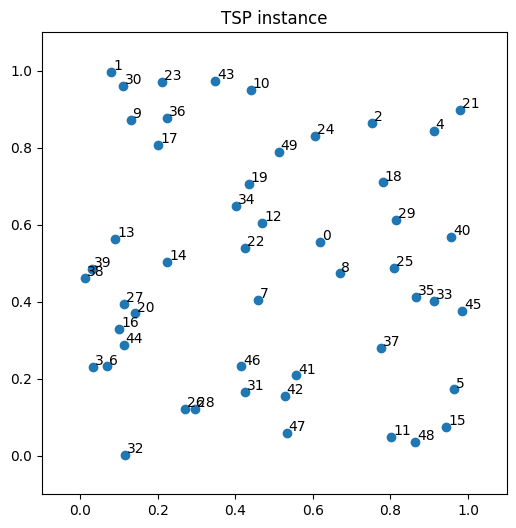

At generation 0. Best current fitness: 23.28134086503163
At generation 100. Best current fitness: 11.435970679778483
At generation 200. Best current fitness: 9.455281750682325
At generation 300. Best current fitness: 8.766603093384044
At generation 400. Best current fitness: 8.385401453028184
At generation 500. Best current fitness: 8.102603412989717
At generation 600. Best current fitness: 7.956834937574356
At generation 700. Best current fitness: 7.670383530207093
At generation 800. Best current fitness: 7.586932088824122
At generation 900. Best current fitness: 7.5722795935811815
Best solution from EA: 7.564005444596772 distance, [41, 37, 5, 15, 48, 11, 17, 36, 9, 30, 1, 23, 43, 10, 18, 40, 45, 33, 35, 25, 0, 12, 22, 7, 28, 26, 32, 3, 6, 44, 16, 20, 27, 38, 39, 13, 14, 34, 19, 49, 24, 2, 21, 4, 29, 8, 46, 31, 47, 42]
Best from greedy algorithm: 6.653219277529493 distance, [13, 39, 38, 27, 20, 16, 44, 6, 3, 32, 26, 28, 31, 46, 42, 41, 47, 11, 48, 15, 5, 45, 33, 35, 25, 29, 18, 2, 24,

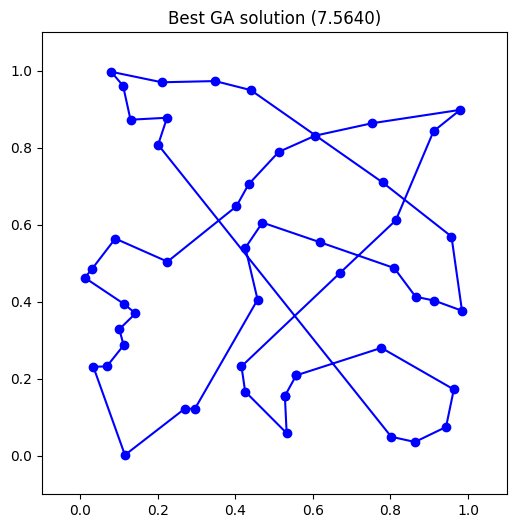

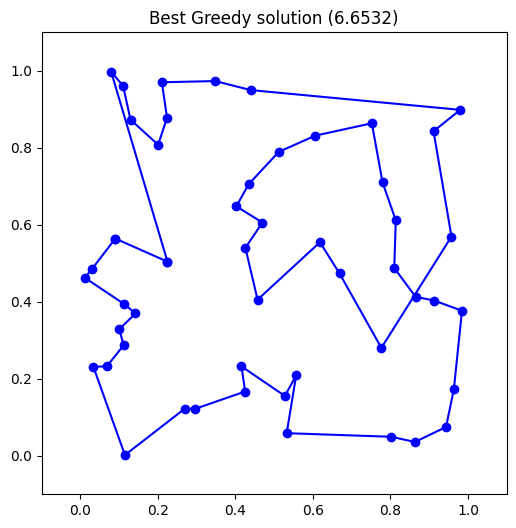

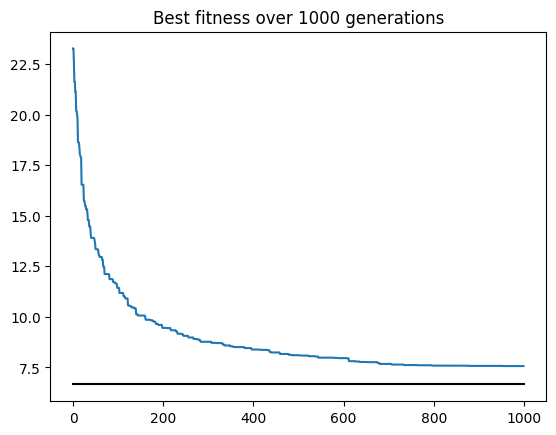

In [8]:
# Travelling Salesman Problem parameters and setup
NODES = 50
tsp = TSP(NODES)
tsp.plot(show_order=True, title='TSP instance')

# Setting up the benchmark: greedy solver
greedy_solver = GreedySolver(tsp)
greedy_solutions = greedy_solver.get_solutions()
greedy_fitnesses = [tsp.evaluate(e) for e in greedy_solutions]
best_greedy_solution = greedy_solutions[np.argmin(greedy_fitnesses)]
best_greedy_fitness = np.min(greedy_fitnesses)

# Parameters for the experiment
MAX_NO_OF_ITERATIONS = 1000
PRINT_EVERY_N_ITERATIONS = 100
initial_population = create_random_population(500, NODES)

# TODO: provide the operators you have created down below!
ea = EvolutionWrapper(initial_population,
                      selection_fn=select, 
                      mutation_fn=mutate, 
                      crossover_fn=None,
                      evaluation_fn=tsp.evaluate)

# Running the EA
for gen_no in range(MAX_NO_OF_ITERATIONS):
    population, fitnesses = ea.step()
    if gen_no % PRINT_EVERY_N_ITERATIONS == 0:
        print(f"At generation {gen_no}. Best current fitness: {np.min(fitnesses)}")

# Printing and plotting results
best_solution_index = np.argmin(fitnesses)
best_solution = population[best_solution_index]
best_fitness = fitnesses[best_solution_index]
print(f"Best solution from EA: {best_fitness} distance, {best_solution}")
print(f"Best from greedy algorithm: {best_greedy_fitness} distance, {best_greedy_solution}")

tsp.plot(best_solution, title=f'Best GA solution ({best_fitness:.4f})')
tsp.plot(best_greedy_solution, title=f'Best Greedy solution ({best_greedy_fitness:.4f})')

plt.plot(range(len(ea.fitness_history)), ea.fitness_history)
plt.plot((0, len(ea.fitness_history)), (best_greedy_fitness, best_greedy_fitness), 'k-')
plt.title(f"Best fitness over {MAX_NO_OF_ITERATIONS} generations")
plt.show()
    